In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve, average_precision_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

warnings.filterwarnings("ignore", category=FutureWarning, message=".*observed=False is deprecated.*")

In [19]:
titanic = pd.read_csv('Titanic.csv')

print("Train dataset: ", titanic.columns)

Train dataset:  Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


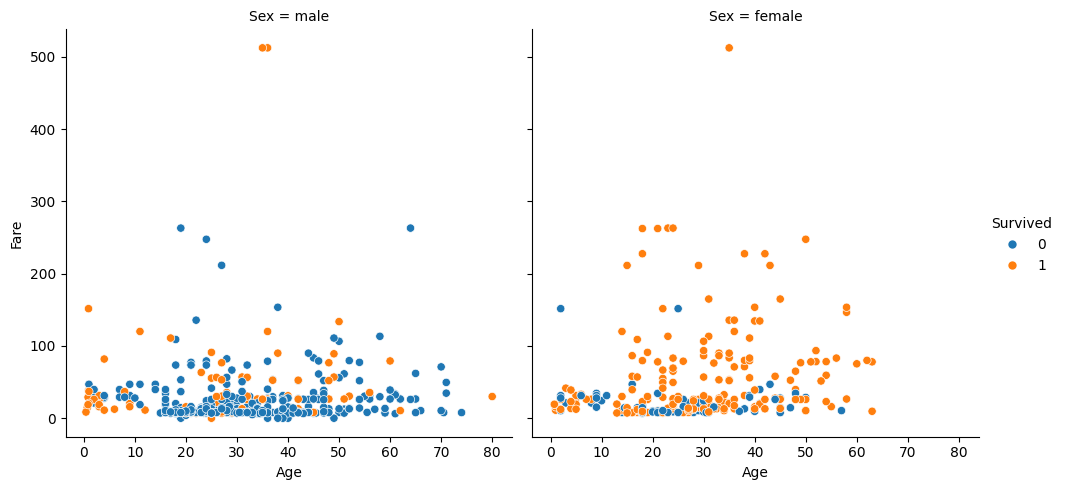

In [20]:
sns.relplot(titanic, x='Age', y='Fare', hue='Survived', col='Sex')

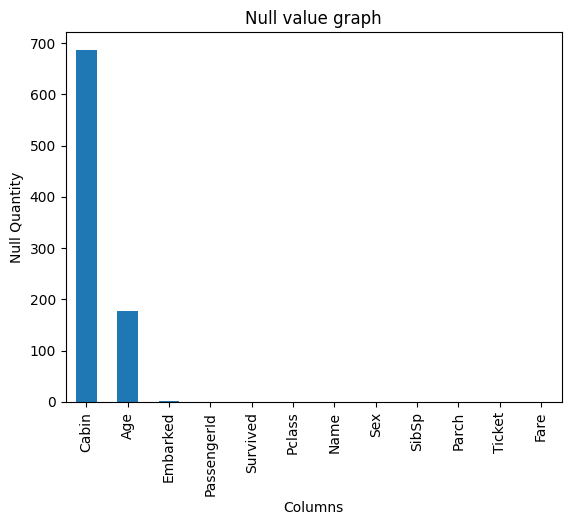

In [21]:
nulls = titanic.isnull().sum().sort_values(ascending=False)
nulls.plot(kind='bar')
plt.title('Null value graph')
plt.xlabel('Columns')
plt.ylabel('Null Quantity')
plt.show()
#Cabin: 687 Age: 177 Embarked: 2

In [22]:
titanic.nunique()
titanic_eda = titanic.copy()

fare_bins = [0, 10, 50, 100, np.inf]
fare_labels = ['Low', 'Medium', 'High', 'Very High']
titanic_eda['FareCat'] = pd.cut(titanic_eda['Fare'], bins=fare_bins, labels=fare_labels)

age_bins = [0, 12, 18, 35, 60, np.inf]
age_labels = ['Infant', 'Teen', 'Young Adult', 'Adult', 'Senior']
titanic_eda['AgeCat'] = pd.cut(titanic_eda['Age'], bins=age_bins, labels=age_labels)

<Axes: xlabel='FareCat', ylabel='Survived'>

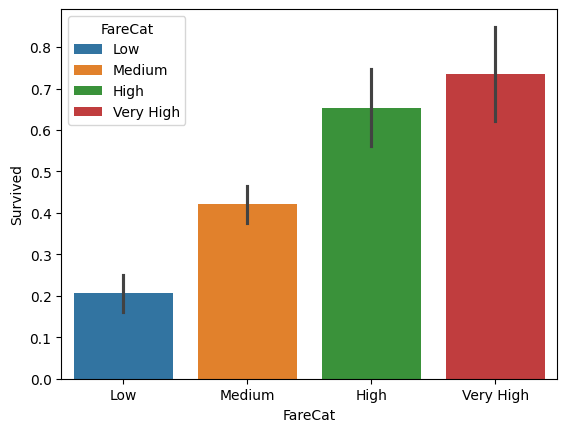

In [23]:
sns.barplot(data=titanic_eda, x='FareCat', y='Survived', hue='FareCat')

<Axes: xlabel='AgeCat', ylabel='Survived'>

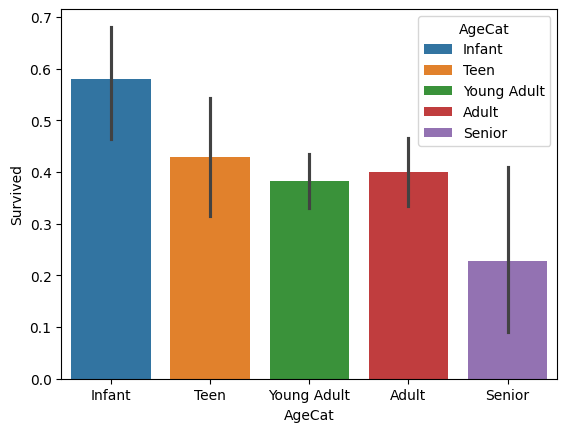

In [24]:
sns.barplot(data=titanic_eda, x='AgeCat', y='Survived', hue='AgeCat')

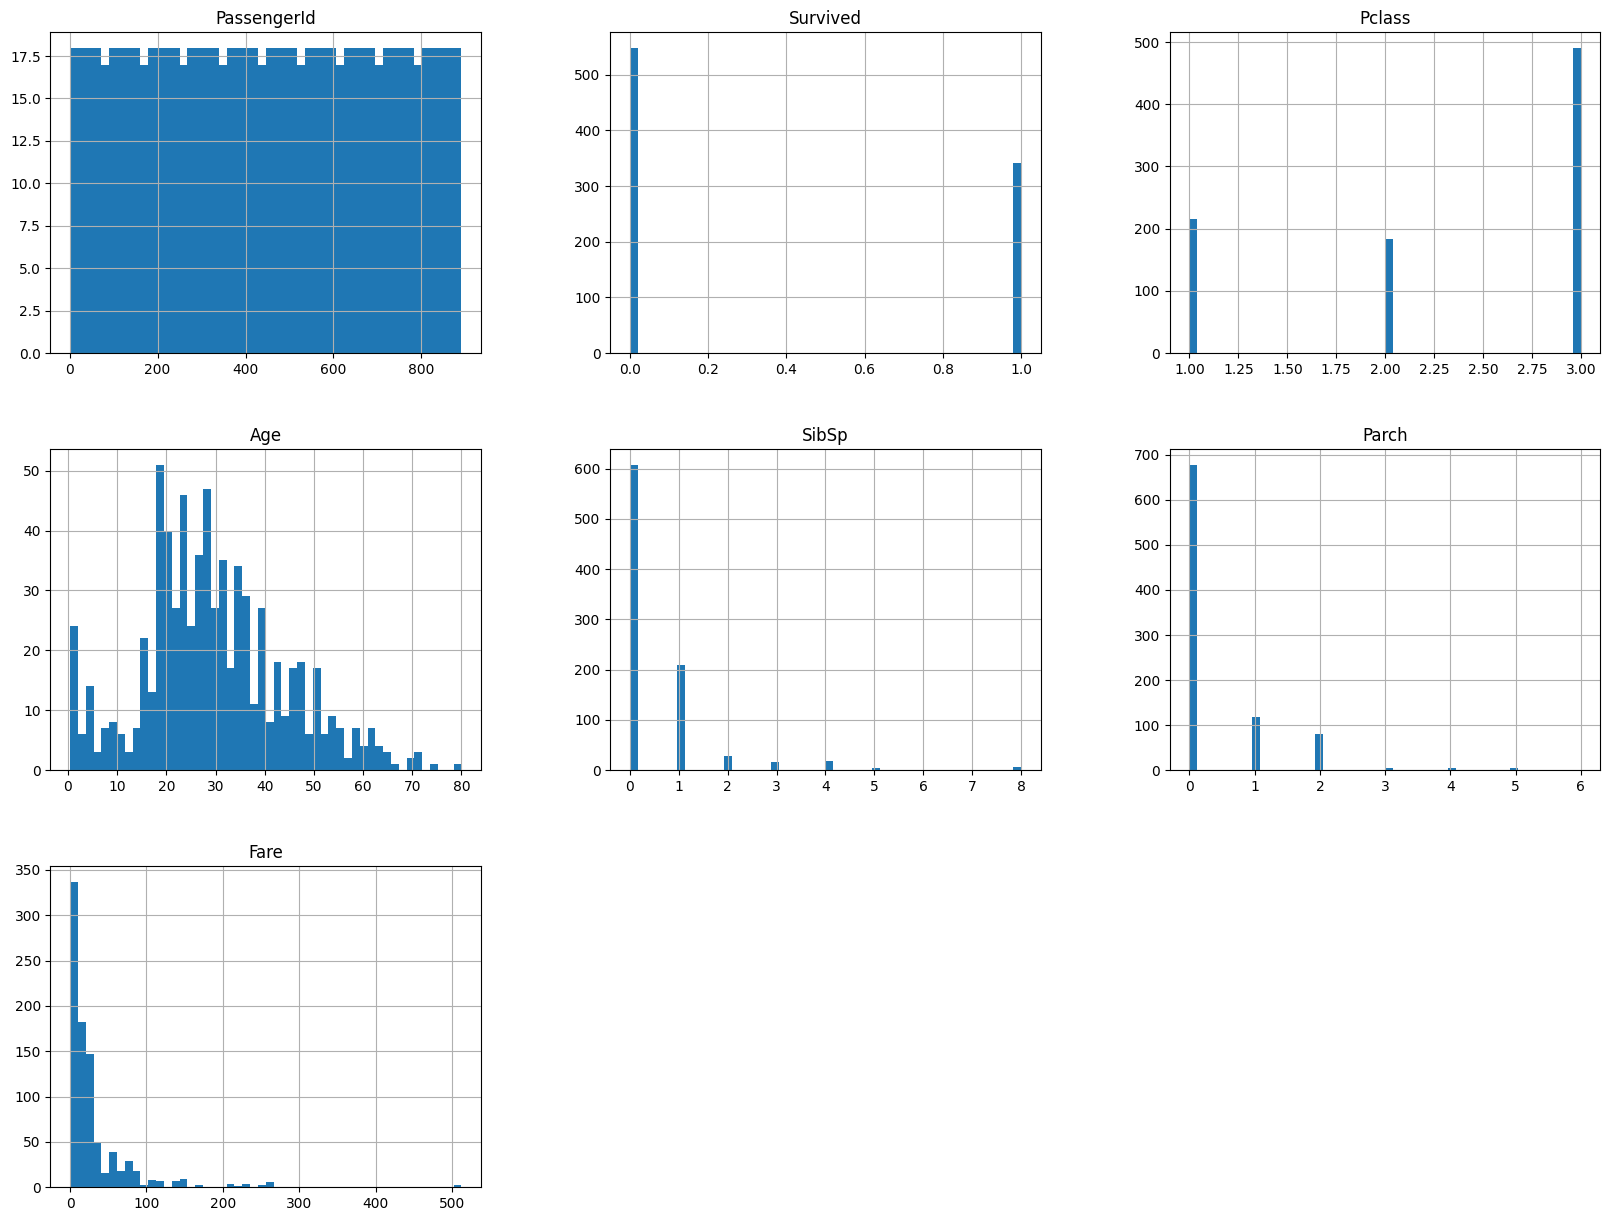

In [25]:
titanic_eda.hist(bins=50, figsize=(20, 15))
plt.show()

In [26]:
titanic.dropna(subset=['Embarked'], inplace=True)
X = titanic.drop(columns='Survived')
Y = titanic['Survived']

In [27]:
X['Title'] = X['Name'].str.extract(', ([A-Za-z]+)\.')

fare_bins = [0, 10, 50, 100, np.inf]
fare_labels = ['Low', 'Medium', 'High', 'Very high']
X['FareCat'] = pd.cut(X['Fare'], bins=fare_bins, labels=fare_labels)

age_bins = [0, 12, 18, 35, 60, np.inf]
age_labels = ['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']
X['Age'] = X['Age'].fillna(X['Age'].median())
X['AgeCat'] = pd.cut(X['Age'], bins=age_bins, labels=age_labels)

X['Pclass'] = X['Pclass'].apply(str)

X.drop(columns=['PassengerId', 'Name', 'Age', 'Ticket', 'Fare', 'Cabin'], inplace=True)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.23, stratify=titanic['Sex'], random_state=42)

In [28]:
sibsp_ix, parch_ix = 0, 1
class CombinedAttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        IsAlone = X[:, sibsp_ix] + X[:, parch_ix]
        IsAlone = np.where(IsAlone > 0, 1, 0)
        X = np.c_[X, IsAlone]

        return X

In [29]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attrib_adder', CombinedAttributeAdder()),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

full_pipeline = ColumnTransformer([
    ('num_attribs', num_pipeline, ['SibSp', 'Parch']),
    ('cat', cat_pipeline, ['Sex', 'Pclass', 'Embarked', 'Title', 'AgeCat', 'FareCat'])
])

processed_X_train = full_pipeline.fit_transform(X_train)
processed_X_test = full_pipeline.transform(X_test)
processed_X_train.dtype

dtype('float64')

In [30]:
lr = LogisticRegression()
lr.fit(processed_X_train, Y_train)
train_pred = lr.predict(processed_X_train)
test_pred = lr.predict(processed_X_test)
print(f'Accuracy: {accuracy_score(test_pred, Y_test)}')
#print(f'Classification report{classification_report(Y_train, train_pred)}')
#print(f'Classification report{classification_report(Y_test, test_pred)}')

Accuracy: 0.8780487804878049


0.7996779733791326


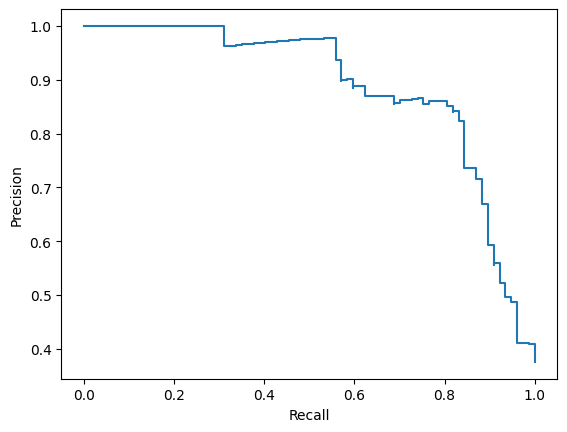

In [31]:
Y_pred = cross_val_predict(lr, processed_X_train, Y_train, cv=5)
accuracys = cross_val_score(lr, processed_X_train, Y_train, cv=5)
precision, recall, _ = precision_recall_curve(Y_test, lr.predict_proba(processed_X_test)[:, 1])

print(accuracys.mean())
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [32]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=4000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        max_features='sqrt',
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'k-Nearest Neighbors': KNeighborsClassifier(),
}
results = {}

for model_name, model in models.items():
    model.fit(processed_X_train, Y_train)
    Y_pred = model.predict(processed_X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    results[model_name] = accuracy

    #print(f'{model_name} accuracy: {accuracy:.4f}')
    #print(f'Classification report: {classification_report(Y_test, Y_pred)}')
    #print(f'Confusion Matrix: {confusion_matrix(Y_test, Y_test)}')

for model_name, accuracy in results.items():
    print(f'{model_name}: {accuracy:.4f}')

Logistic Regression: 0.8780
Decision Tree: 0.8439
Random Forest: 0.8537
Gradient Boosting: 0.8537
Support Vector Machine: 0.8585
k-Nearest Neighbors: 0.8585


<ipython-input-34-c5bf86c99cf2>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accurate, palette='viridis')


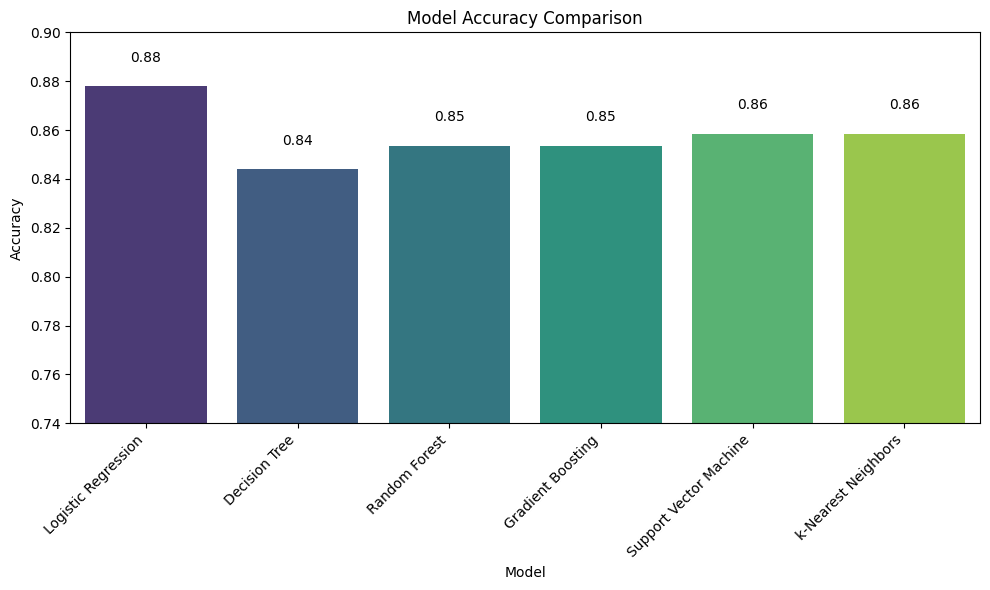

In [34]:
model_names = list(results.keys())
accurate = list(results.values())

plt.figure(figsize=(10, 6))
for i, accuracy in enumerate(accurate):
    plt.text(i, accuracy + 0.01, f'{accuracy:.2f}', ha='center', color='black', fontsize=10)
sns.barplot(x=model_names, y=accurate, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.74, 0.9)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Importing:**
Imported all the required and necessary packages like numpy (for array and numeric operations), pandas (for dataset related operations), seaborn and matplotlib (for graphical analysis) and sklearn (to use ML algorithms)

**Pandas** Created three dataset variables to store loaded datasets

Created a **relational plot** using seaborn to analyze survival rate based on age and gender

Found **null** values in the dataset, by plotting matplot graph

For **EDA** compared how age and fare affect survival rate

**Separated** features(excluding embarked) and targets into X and Y respectively

**Pre-Processing**:
num pipeline: fills missing value using median, ,Removes outliers
cat pipeline: fills "" values using most frequent, encodes categorial int
full pipeline: applies num and cat pipeline to problem causing columns

**Applied** logistic regression and cross validation(5)
lr, dt, rf, gb, svm, knn since they do handy with categorial data
